# Coursework 1: Learning Learning, From Scratch

_COMP0169 Team_

__Niloy J. Mitra & Tobias Ritschel__

TAs:  __Remy Sabathier, Yilin Liu & Zican Wang__

The total points for this exercise is 100.

Please refer to Moodle submission page for the due date.


## Submission instructions:

Coursework submissions must comprise of a zipped folder. Inside this zip, you should have two things.


1.   This Jupyter notebook, containing your code and written comments.
2.   A "models/" folder, containing your trained model weights.


 In the notebook, cells that need to be changed are clearly stated with a &#9998; symbol and you are not allowed to change the rest of the code in any way. Descriptive answers must be contained in the markdown blocks starting with "_Your reply_:". Code must only be written in the space inside the `#begin_solution ... #end_solution` blocks. Code written outside these blocks will not be processed or evaluated.

Please, do not change `#begin_test ... #end_test` blocks, these blocks are for TAs.

Each exercise must be implemented from scratch. Unless differently specified, only numpy and matplotlib are allowed. The libraries are imported in [the package cell](#packages) and cannot be modified.



**Questions:**

[Question 1](#question1): Linear Fitting (10 points)

[Question 2](#question2): Image retrieval (15 points)

[Question 3](#question3): Image Denoising (30 points)

[Question 4](#question4): Texture Synthesis (15 points)

[Question 5](#question5): Neural Implicit Representation (30 points)

## Datasets

We will be using several datasets for the coursework: _IRIS_ , _MNIST_ , _CelebA_ , _NoisyOCR_.

_IRIS_ and _MNIST_ datasets will be downloaded directly in the notebook using the `skdataset` library. Keep in mind that you will need to be connected to Internet to be able to download the datasets. If you want to work offline, you are free to save your dataset to npy file locally and load them while offline although this is not officially supported.

_CelebA_ and _NoisyOCR_ are provided separately in a zip file; make sure to unzip it and the unzipped folder is placed in the same directory as the notebook.


**_IRIS_**: The _IRIS_ dataset contains the following features in order: _sepal length_, _sepal width_, _petal length_, _petal width_. Classes names are: __Iris Setosa__ for label **0**, __Iris Versicolour__ for label **1**, and __Iris Virginica__ for label **2**.

**_MNIST_**: _MNIST_ is a dataset composed of images of handwritten digits.

**_NoisyOCR_**: _NoisyOCR_ is a dataset composed of
images of noisy OCR scans, along with corresponding clean target images.

The script will generate two subsets for each of the two datasets, a training subset (**X\_dataset** and **Y\_dataset** with **dataset** the name of the dataset) and a test subset (**X\_dataset\_test** and **Y\_dataset\_test**).

We will test correctness of your code on _Hidden_ set.

**Warning:** as _Hidden_ may have different dimensions from _IRIS_ and _MNIST_, hard-coded solutions may not work, thus resulting in lower grades. You need to make sure that your code would work if applied on a different number of samples and a different number of features/pixels.

## Instructions for the other datasets zip file:
**Download Link:** https://geometry.cs.ucl.ac.uk/mlvc/cw_datasets.zip

You can download this zip locally, unzip it and keep the folder in the same directory as your Notebook. There is code provided below to download and unzip it. If you're using Colab, the downloaded content will remain only while the session is active. When you start a new session, you'd have to download it again.

**Google Drive:** For a more permanent solution, you can upload the *unzipped* folder to your own Google Drive, and mount your drive in the notebook. Code is provided below, to mount the drive.

You can use either options, and a variable `drive_mount` is provided to toggle between the two. Set this variable accordingly.

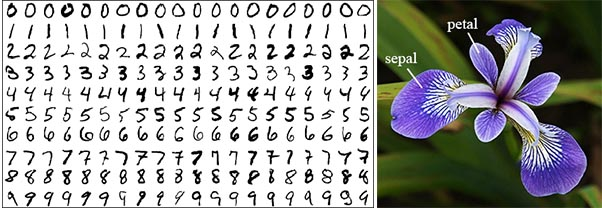

The following cell imports all packages needed in the coursework. You are not allowed to use any other packages than the ones listed below.
<a name='packages'></a>

In [62]:
# Importing packages
import numpy as np
import random
import os

import matplotlib.pyplot as plt

from scipy import optimize
from sklearn import datasets as skdataset
from sklearn.model_selection import train_test_split
from pathlib import Path

import os
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.utils.data import Dataset

import imageio
from PIL import Image
import cv2

from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio
from IPython.display import Video

from torchvision import models, transforms
%matplotlib inline

The following code imports the drive module from Colab. This code will only run on Colab. If you're not using Colab, comment this code out, or don't run this cell.

In [63]:
#from google.colab import drive

#Unmount any previously mounted drive if needed.
#Feel free to uncomment below line when you need to unmount Drive

#drive.flush_and_unmount()

The following cell sets the `drive_mount` variable. Set it to `True` if your Dataset folder is on drive. If you plan to use the Dataset folder locally, then set this to `False`

In [64]:
drive_mount = False

In [65]:
# Setting the seed
RAND_ST = 42
random.seed(RAND_ST)
#begin_test

#end_test



## Data Loading

The following cells are used to load IRIS and MNIST datasets.

In [66]:
def load_iris_dataset(num_classes=2):
    # Load the datadet from SkDataset
    iris = skdataset.load_iris()
    X = iris.data
    Y = iris.target
    # Reduce the number of classes
    idx = Y < num_classes
    X = X[idx]
    Y = Y[idx]
    return X, Y

In [67]:
def load_mnist_dataset(num_classes=2):
    # Load the datadet from SkDataset
    X, Y = skdataset.fetch_openml('mnist_784', version=1, return_X_y=True,as_frame=False)
    Y = Y.astype(np.int64)
    # Reduce the number of classes
    idx = Y < num_classes
    X = X[idx]
    Y = Y[idx]
    return X, Y

def load_mnist_dataset_onevsall(class_id=7):
    # Load the datadet from SkDataset
    X, Y = skdataset.fetch_openml('mnist_784', version=1, return_X_y=True,as_frame=False)
    Y = Y.astype(np.int64)
    # One versus all
    idx = Y == class_id
    Y[~idx] = 0
    Y[idx]  = 1
    return X, Y

## Functions for visualization

In [68]:
def plot_correlation(X1, X2):
    # Plot both variables
    plt.figure(figsize=(8, 6))
    plt.clf()
    plt.scatter(X1, X2, edgecolor='k')
    line = np.linspace(min(X1.min(), X2.min()), max(X1.max(), X2.max()), 20)
    plt.plot(line, line, 'r')
    plt.xlabel('Variable 1')
    plt.ylabel('Variable 2')
    plt.show()

In [69]:
def plot_eigenvecs(stacked_images, n_rows, n_columns, img_shape=None, channels=1):
    n_images, n_dims = stacked_images.shape
    plt.figure()
    for i in range(n_rows * n_columns):
        plt.subplot(n_rows, n_columns, i + 1)
        if channels == 1:
            # Normalize eigen vector to [0, 255] range
            eigenvector = stacked_images[i] - np.min(stacked_images[i])
            eigenvector /= np.max(eigenvector) + 1e-8
            eigenvector = (eigenvector * 255).astype(np.uint8)
            plt.imshow(np.reshape(eigenvector, [int(np.sqrt(n_dims)), int(np.sqrt(n_dims))]), cmap='gray')
        elif channels == 3:
            # Normalize eigen vector to [0, 255] range for each channel
            eigenvector = stacked_images[i].reshape(img_shape[0], img_shape[1], 3)
            eigenvector -= np.min(eigenvector)
            eigenvector /= np.max(eigenvector) + 1e-8
            eigenvector = (eigenvector * 255).astype(np.uint8)
            plt.imshow(eigenvector)
        plt.axis('off')
    plt.show()

def plot_images(stacked_images, n_rows, n_columns, titles, num_channels=1):
    n_images, n_dims = stacked_images.shape
    plt.figure()
    for i in range(n_rows * n_columns):
        plt.subplot(n_rows, n_columns, i + 1)

        if num_channels == 1:
            # Grayscale image
            plt.imshow(np.reshape(stacked_images[i], [int(np.sqrt(n_dims)), int(np.sqrt(n_dims))]), cmap='gray', vmin=0, vmax=1)
        elif num_channels == 3:
            # RGB image
            image = np.reshape(stacked_images[i], [int(np.sqrt(n_dims // 3)), int(np.sqrt(n_dims // 3)), 3])
            image = np.clip(image, 0, 1)  # Ensure pixel values are within [0, 1] range
            plt.imshow(image)
        else:
            raise ValueError("Unsupported number of channels. Use num_channels=1 for grayscale or num_channels=3 for RGB.")

        plt.axis('off')

        if len(titles) == n_rows * n_columns:
            plt.title(titles[i])

    plt.show()

def plot_images_with_text(images, titles, texts=None):
    N_cols = len(images)
    N_rows = len(images[0])

    fig, axs = plt.subplots(N_rows, N_cols, figsize=(20, 15))

    if titles is not None:
        for i, ax in enumerate(axs[0]):
            ax.set_title(titles[i])

    for i, img_col in enumerate(images):
        for j, img in enumerate(img_col):
            if len(img.shape) == 2:
                axs[j,i].imshow(img, interpolation='nearest', cmap='gray')
            else:
                axs[j,i].imshow(img, interpolation='nearest')
            axs[j,i].axis('off')
            if texts is not None:
                axs[j,i].text(0.5,-0.1, str(texts[j][i])[:4], size=10, ha="center", transform=axs[j,i].transAxes)
    plt.show()


In [70]:
def plot_images_horizontal(imgs):
    num_imgs = len(imgs)
    f = plt.figure(figsize=(40, 15))
    for i in range(num_imgs):
        f.add_subplot(1, num_imgs, i+1)
        plt.imshow(imgs[i])
    plt.show()

In [71]:
def true_positive(Y_test, y_pred):
    mask = (Y_test == 1)
    tp = (Y_test[mask] == y_pred[mask]).sum()
    return tp.item()

def true_negative(Y_test, y_pred):
    mask = (Y_test == 0) | (Y_test == -1)
    tn = (Y_test[mask] == y_pred[mask]).sum()
    return tn.item()

def false_negative(Y_test, y_pred):
    mask = (y_pred == 0) | (y_pred == -1)
    tn = (Y_test[mask] != y_pred[mask]).sum()
    return tn.item()

def false_positive(Y_test, y_pred):
    mask = (y_pred == 1)
    tn = (Y_test[mask] != y_pred[mask]).sum()
    return tn.item()

def plot_confusion_matrix(Y_test, y_pred):
    tp = true_positive(Y_test, y_pred)
    tn = true_negative(Y_test, y_pred)
    fp = false_positive(Y_test, y_pred)
    fn = false_negative(Y_test, y_pred)
    cf = np.array([[tn, fp], [fn, tp]])
    fig, ax = plt.subplots()
    ax.matshow(cf, cmap=plt.cm.Blues)
    for i in range(2):
        for j in range(2):
            c = cf[i,j]
            ax.text(j, i, str(c), va='center', ha='center')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.show()

## Data Loading

In the following cells, the dataset is created with proper splits between training and test set.

_IRIS_ dataset

In [72]:
X, Y = load_iris_dataset(num_classes=3)
X_iris, X_iris_test, Y_iris, Y_iris_test = train_test_split(X, Y, test_size=0.1, random_state=RAND_ST) # 90% training and 10% test

_MNIST_ **dataset**

In [73]:
X, Y = load_mnist_dataset(num_classes=10)
X = X / 255.0
X_mnist, X_mnist_test, Y_mnist, Y_mnist_test = train_test_split(X, Y, test_size=0.1, random_state=RAND_ST) # 90% training and 10% test

**Code for handling the Dataset zip file**

The following cell mounts your drive if `drive_mount` is `True`

In [74]:
if drive_mount:
  drive.mount('/content/drive')

Set `dataset_path` to Drive or local directory.

In [75]:
if drive_mount:
  dataset_path = '/content/drive/MyDrive/cw_datasets/'
  assert(os.path.exists(dataset_path))
  # Set this path to your appropriate drive path
else:
  dataset_path = "./cw_datasets"
  # In this case, the datasets path is assumed to be in the same directory as this notebook

  if not os.path.exists("./cw_datasets"):
    !wget https://geometry.cs.ucl.ac.uk/mlvc/cw_datasets.zip
    !unzip -q -o cw_datasets.zip

## 1. Linear Fitting (10 points)
<a name='question1'></a>

[a)](#question1a) Implement the normal equation solver function **nsolve**, which takes as input the matrix **X** and the target vector **y** and returns the optimized weights **w**. Test your code with your own mockup/randomly created data. (**5 points**)

[b)](#question1b) Implement **line_fit(X,y)** which should fit a linear function to the input data. Test your implementation on the following task: predict with linear fitting the _petal length (cm)_ of the Iris dataset using the three remaining variables as inputs (_sepal length (cm)_, _sepal width (cm)_ and _petal width (cm)_). Report the L2 loss on the validation set and plot a graph showing the correlation between y and your prediction on the test set. (**2 points**)

[c)](#question1c) Implement **poly_fit(X,y)** which should fit a 2nd degree polynomial to the input data. Test your implementation on the following task: predict with the polynomial the petal width (cm) of the _IRIS_ dataset using the three remaining variables as inputs (sepal length (cm), sepal width (cm), petal length (cm)). The 2nd degree polynomial should consider all possible pairwise terms, i.e. $w_1x^2 + w_2xy+ w_3y^2 + w_4x+ w_5y+ w_6$ in the case of two input variables $x$ and $y$. Report the L2 loss on the validation set and plot a graph showing the correlation between $y$ and your prediction on the test set. (**3 points**)

**Question 1a**
<a name='question1a'></a>

Implement the nsolve function

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [76]:
def nsolve(X,y):
    """
    Write your implementation of nsolve here.

    Arguments:
    X : Data matrix
    y : Labels

    Returns:
    w : Weights
    """

    #begin_solution
    w = np.linalg.pinv(X) @ y 
    #end_solution


    return w

Testing your code on mockup/randomly created data.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [77]:
"""
After implementing nsolve, test it below on some mock data using np.random
"""

#begin_solution
np.random.seed(RAND_ST)
X = np.random.randn(100, 5)
y = np.random.randint(0,2,size=(100,))

w = nsolve(X, y)

print("Computed weights (w):\n", w)

# Verify by comparing with numpy's least squares solution
w_lstsq, _, _, _ = np.linalg.lstsq(X, y, rcond=None)
print("\nnp.linalg.lstsq weights:\n", w_lstsq)

print("\nAre the two results close?", np.allclose(w, w_lstsq))
#end_solution


Computed weights (w):
 [-0.04052834  0.07154635 -0.05977785  0.08800719 -0.02587225]

np.linalg.lstsq weights:
 [-0.04052834  0.07154635 -0.05977785  0.08800719 -0.02587225]

Are the two results close? True


**Question 1b**
<a name='question1b'></a>

Implement the line_fit function and test

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [78]:
def line_fit(X,y):
    """
    Write your implementation of line_fit here.

    Arguments:
    X : Data matrix
    y : Labels

    Returns:
    w : Weights
    l2_error : L2 Prediction error using learned w
    """

    #begin_solution
    
    y = y.reshape(-1, 1)
    
    X_aug = np.hstack([X, np.ones((X.shape[0], 1))])
    
    w = nsolve(X_aug, y)
    
    y_pred = X_aug @ w
    
    l2_error = np.mean((y - y_pred) ** 2)
    #end_solution

    return w, l2_error


Testing your code on _IRIS_

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
"""
After implementing line_fit, test it below on IRIS Train set.
Print the L2 error on the Training set.
"""

#begin_solution
#remove petal length (3rd column) to use other features to predict it
X_train = np.delete(X_iris, 2, axis=1)  
y_train = X_iris[:, 2]                  

X_test = np.delete(X_iris_test, 2, axis=1)
y_test = X_iris_test[:, 2]

# Fit model on training set
w, train_error = line_fit(X_train, y_train)
print(f"L2 error on training set: {train_error:.4f}")

#end_solution


L2 error on training set: 0.0925
L2 error on test set: 0.1625


&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

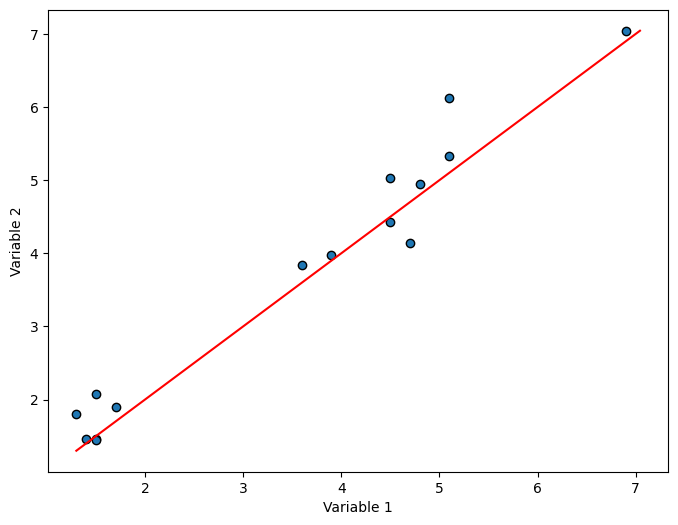

In [ ]:
"""
After implementing line_fit, test it below on IRIS Test set.
Print the L2 error with respect to Test set.
"""

#begin_solution
X_test_aug = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
y_pred_test = X_test_aug @ w
test_error = np.mean((y_test.reshape(-1,1) - y_pred_test) ** 2)
print(f"L2 error on test set: {test_error:.4f}")
#end_solution



Showing the correlation between X and y.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
"""
Below, plot and display the correlation between true y and predicted values.
"""
#begin_solution
plot_correlation(y_test, y_pred_test)
#end_solution


'\nBelow, plot and display the correlation between true y and predicted values.\n'

Do not write anything in the cell below, it is for TAs

In [82]:
#begin_test

#end_test


**Question 1c**
<a name='question1c'></a>

Implement the poly_fit function and test

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [83]:
def poly_fit(X,y):
    """
    Write your implementation of poly_fit here.

    Arguments:
    X : Data matrix
    y : Labels

    Returns:
    w : Weights
    l2_error : L2 prediction error using learned w
    """

    #begin_solution

    #end_solution


    return w, l2_error

Testing your code on _IRIS_.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [84]:
"""
After implementing poly_fit, test it below on IRIS Training set.
Print L2 error with respect to training set.
"""

#begin_solution

#end_solution


'\nAfter implementing poly_fit, test it below on IRIS Training set.\nPrint L2 error with respect to training set.\n'

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [85]:
"""
After implementing poly_fit, test it below on IRIS Test set.
Print L2 error with respect to test set.
"""

#begin_solution

#end_solution


'\nAfter implementing poly_fit, test it below on IRIS Test set.\nPrint L2 error with respect to test set.\n'

Showing the correlation between X and y.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [86]:
"""
Below, plot and display the correlation between true y and predicted values
"""

#begin_solution

#end_solution


'\nBelow, plot and display the correlation between true y and predicted values\n'

Do not write anything the cell below, it is for TAs

In [87]:
#begin_test

#end_test


## 2. Image retrieval (15 points)
<a name='question2'></a>

Image retrieval means there is a query, and there is a database. Your job is to find the most similar image from the database. What is considered similar depends on the features used.

[a)](#question2a) Implement four different feature spaces: rgb distance, histogram distance, vgg features and vgg features gram matrix. You can only use the torchvision and torch library (**4 points** + **1 points** for your vectorised version (return features by a batch_size instead of for loop))

[b)](#question2b) Implement an algorithm to retrieve the index of the most similar image from the database. we will use a hidden query and hidden DB to test this. make sure your code works with all DB sizes and resolutions. For testing, you are given a single database with N entries and M querys.
(**4 points** + **1 points** for your vectorised version (return features by a batch_size instead of for loop))

The hidden dataset images size are from (64, 64, 3) to (256, 256, 3).

[c)](#question2c) Discuss and document, why each of the M-times-N results is what it is.
(**5 points**)

**Question 2a**



&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [88]:
import gdown
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

# Download the zip file from Google Drive
output = 'dataset.zip'
gdown.download(id='1udnykJuPVa219EB4X0zSaW9Umi-pGvVm', output=output, quiet=False)


# Unzip the file to the specified folder
!unzip -qq dataset.zip -d ./dataset

ModuleNotFoundError: No module named 'gdown'

In [ ]:
if drive_mount:
  query_img = Image.open('/content/dataset/Image_Retrieval_student_data/query.JPEG')
else:
  query_img = Image.open('./dataset/Image_Retrieval_student_data/query.JPEG')
query_img

In [ ]:
database_imgs_list = []
for i in range(5):
    if drive_mount:
        tmp_img = Image.open(f'/content/dataset/Image_Retrieval_student_data/{i + 1}.JPEG')
    else:
        tmp_img = Image.open(f'./dataset/Image_Retrieval_student_data/{i + 1}.JPEG')
    database_imgs_list.append(tmp_img)

plt.figure()
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(database_imgs_list[i])
plt.show()

In [ ]:
vgg = None
# Load the pretrained vgg19 model, we recommend you to use torchvision.models. And you can search to find a pretrained vgg19 model

#begin_solution

#end_solution


In [ ]:
def get_features(img, mod):
    """
    Get the features of the image

    Arguments:
    img : an image, PIL image; or a list of images, [PIL image, PIL image, ...]
    mod : the model to use to extract features
    mod == 1: return the image
    mod == 2: return the histogram
    mod == 3: return the vgg19 feature
    mod == 4: return the vgg19 feature gram matrix

    Returns:
    features : Features of the image as a numpy array; or a list of features numpy array, [features, features, ...]
    """
    features = None
    #begin_solution

    #end_solution

    return features

In [ ]:
def find_img(query_img, database_imgs_list, mod):
    """
    Find the closest image in the database to the query image.

    Arguments:
    query_img: the query image, PIL image
    database_imgs_list : a list of images, [PIL image, PIL image, ...]
    mod : the model to use to extract features
    mod == 1: return the image
    mod == 2: return the image's histogram
    mod == 3: return the vgg19 festure of the image
    mod == 4: return the vgg19 gram feature of the image

    Returns:
    index: the index of the closest image in the database list
    distance_list: the list of distances between the query image and each image in the database list
    """
    index = None
    distance_list = []
    #begin_solution

    #end_solution

    return index, distance_list

Test your results

In [ ]:
def test_retrieval(query_img, database_imgs_list):
    rgb_distance = [0, 0, 0, 0, 0]
    histogram_distance = [0, 0, 0, 0, 0]
    vgg_distance = [0, 0, 0, 0, 0]
    vgg_gram_distance = [0, 0, 0, 0, 0]

    # you can use the function you implemented above to get the distance to visualize the results
    # nothing here for grade, just for you to debug & visualize
    # ----
    res_rgb, rgb_distance = find_img(query_img, database_imgs_list, mod = 1)
    res_his, histogram_distance = find_img(query_img, database_imgs_list, mod = 2)
    res_vgg, vgg_distance = find_img(query_img, database_imgs_list, mod = 3)
    res_vgg_gram, vgg_gram_distance = find_img(query_img, database_imgs_list, mod = 4)
    # ----

    plt.figure(figsize=(20, 3))
    plt.subplot(1, 5, 1)
    plt.imshow(query_img)
    plt.title('Query Image')
    plt.subplot(1, 5, 2)
    plt.imshow(database_imgs_list[res_rgb])
    plt.title('rgb distance closest img')
    plt.subplot(1, 5, 3)
    plt.imshow(database_imgs_list[res_his])
    plt.title('histogram distance closest img')
    plt.subplot(1, 5, 4)
    plt.imshow(database_imgs_list[res_vgg])
    plt.title('vgg distance closest img')
    plt.subplot(1, 5, 5)
    plt.imshow(database_imgs_list[res_vgg_gram])
    plt.title('vgg gram distance closest img')
    plt.show()


    plt.figure(figsize=(20, 3))
    plt.subplot(1, 6, 1)
    plt.imshow(query_img)
    plt.title('Query Image')
    for i in range(5):
        plt.subplot(1, 6, i + 2)
        plt.imshow(database_imgs_list[i])
        plt.title(f'rgb dis: ' + str(round(rgb_distance[i], 3)))
    plt.show()

    plt.figure(figsize=(20, 3))
    plt.subplot(1, 6, 1)
    plt.imshow(query_img)
    plt.title('Query Image')
    for i in range(5):
        plt.subplot(1, 6, i + 2)
        plt.imshow(database_imgs_list[i])
        plt.title(f'histogram dis: ' + str(round(histogram_distance[i], 3)))
    plt.show()


    plt.figure(figsize=(20, 3))
    plt.subplot(1, 6, 1)
    plt.imshow(query_img)
    plt.title('Query Image')
    for i in range(5):
        plt.subplot(1, 6, i + 2)
        plt.imshow(database_imgs_list[i])
        plt.title(f'vgg dis: ' + str(round(vgg_distance[i], 3)))
    plt.show()

    plt.figure(figsize=(20, 3))
    plt.subplot(1, 6, 1)
    plt.imshow(query_img)
    plt.title('Query Image')
    for i in range(5):
        plt.subplot(1, 6, i + 2)
        plt.imshow(database_imgs_list[i])
        plt.title(f'vgg gram dis: ' + str(round(vgg_gram_distance[i], 3)))
    plt.show()

test_retrieval(query_img, database_imgs_list)

Do not write anything in the cell below, it is for the TAs

In [ ]:
#begin_test

#end_test


**Question 2b**

Choose you methodology which will be tested on a hidden dataset

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>


In [ ]:
def get_features_q2b(img):
    """
    Get the features of the image

    Arguments:
    img : an image, PIL image; or a list of images, [PIL image, PIL image, ...]

    Returns:
    features : Features of the image as a numpy array; or a list of features numpy array, [features, features, ...]
    """
    features = None
    #begin_solution

    #end_solution

    return features

In [ ]:
def find_img_q2b(query_img, database_imgs_list):
    """
    Find the closest image in the database to the query image.

    Arguments:
    query_img: the query image, PIL image
    database_imgs_list : a list of images, [PIL image, PIL image, ...]

    Returns:
    index: the index of the closest image in the database list
    distance_list: the list of distances between the query image and each image in the database list
    """
    index = None
    distance_list = []
    #begin_solution

    #end_solution

    return index, distance_list

Do not write anything in the cell below, it is for the TAs

In [ ]:
#begin_test

#end_test


**Question 2c**

_Your reply here:_

## 3. Denoising (30 points)
<a name='question3'></a>

[a)](#question4a) Implement `denoiseGauss(image)` to denoise the image `noisy_image.png` under `cw_datasets/Filtering/` using a
5×5 Gaussian filter. (**5 points**)

[b)](#question4b) Implement a convolutional neural network in Pytorch to denoise an image. We provide you pairs of noisy and
noise-free image patches of size 128×128 for training and testing, under `cw_datasets/Denoising/`. You may use all the infrastructure of `Pytorch`. The network should have sufficient depth and complexity to be able to converge well.  Please use ReLU non-linearities after each layer (**20 points**).

[c)](#question4c) Given the comparison between the Gaussian-kernel denoising and the neural network denoising
methods, discuss which method performs better and why. You should write no more than 5 sentences. (**5 points**)


**Question 3a**
<a name='question3a'></a>

Implement the below functions to denoise the image

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def gkern(l=5, sig=1.):

    #begin_solution

    #end_solution


    return out_kernel

def denoise_gauss(image):

    #begin_solution

    #end_solution


    return denoised_image

Load input image from file

In [ ]:
if drive_mount:
  dataset_path = "/content/drive/MyDrive/cw_datasets/"
else:
  dataset_path = "./cw_datasets/"

noisy_image_filename = os.path.join(dataset_path,"Filtering/noisy_image.png")

Filter the input image

In [ ]:
noisy_image = np.asarray(Image.open(noisy_image_filename).convert('RGB'))
denoised_image = denoise_gauss(noisy_image)
plot_images_horizontal([noisy_image, denoised_image])

**Question 3b**
<a name='question3b'></a>

Implement a neural denoiser using Pytorch

Implement dataset class below. Note that the images output by the `DenoisingDB` dataset should be of size 128 x 128. Crop the original images at the top left corner to get the aforementioned size.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
class DenoisingDB(Dataset):

    def __init__(self, input_imgs_path, cleaned_imgs_path):
        super().__init__()

        #begin_solution

        #end_solution


    def __len__(self):
        #begin_solution

        #end_solution

        return length

    def __getitem__(self, idx):

        #begin_solution

        #end_solution


        return (input_img, cleaned_img)


Implement the Denoising network:

Note that the network need to be sufficiently complex for performing the denoising task successfully. Feel free to experiment with different layers, blocks and operations.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
class DenoisingCNN(nn.Module):
    def __init__(self):
        super(DenoisingCNN, self).__init__()

        #begin_solution

        #end_solution


    def forward(self, x):

        #begin_solution

        #end_solution


        return x

# Create an instance of the network
model = DenoisingCNN()


Implement the reconstruction loss

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def loss_function(prediction, target):
    """
    Calculate the Mean Squared Error (MSE) loss between the prediction and the target.

    Arguments:
    prediction : torch.Tensor
        The predicted image.
    target : torch.Tensor
        The target image for reconstruction.

    Returns:
    loss : torch.Tensor
        The computed loss.
    """

    #begin_solution

    #end_solution


    return loss


Paths to input data

In [ ]:
if drive_mount:
  dataset_path = "/content/drive/MyDrive/cw_datasets/"
else:
  dataset_path = "./cw_datasets/"

input_imgs_path = os.path.join(dataset_path,"Denoising/input_noisy_images/")
cleaned_imgs_path = os.path.join(dataset_path,"Denoising/target_clean_images/")

Write the training loop

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
#begin_solution

#end_solution



Save the model (needed for marking)

In [ ]:
if not os.path.exists("models/"):
  os.makedirs("./models/")
torch.save({"denoiser":denoiser}, "models/denoiser.pth")

Load trained model

In [ ]:
state_dict = torch.load("models/denoiser.pth", weights_only=False)
denoiser = state_dict["denoiser"].to(device)

Plot 5 input images and their relative denoised images side by side. Populate the 3 lists of input, gt and output with 5 images each.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
input_imgs, gt_imgs, output_imgs = [], [], []

#begin_solution

#end_solution


titles = ['Input', 'GroundTruth', 'Output']
plot_images_with_text([input_imgs, gt_imgs, output_imgs],titles,texts=None)


Compute images for both the AE and Gaussian Kernels algorithm from `images`.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
dataset = DenoisingDB(input_imgs_path,cleaned_imgs_path)

images = [dataset[i][0].to(device) for i in range(5)]
targets = [dataset[i][1].to(device) for i in range(5)]
images_ae = []
images_gauss = []

#begin_solution

#end_solution


Now we plot images and PSNR, to compare the two methods

In [ ]:
imgs_plot = [ el.detach().squeeze().cpu().numpy() for el in images]
tgts_plot = [ el.detach().squeeze().cpu().numpy() for el in targets]

In [ ]:
psnrs = [ 0.0 for el in targets ]
for i in range(len(tgts_plot)):
    psnr_ae    = peak_signal_noise_ratio(tgts_plot[i], images_ae[i])
    pnsr_gauss = peak_signal_noise_ratio(tgts_plot[i], images_gauss[i])
    psnrs[i] = ['', psnr_ae, pnsr_gauss, '']

img = [imgs_plot, images_ae, images_gauss, tgts_plot]
titles = ['Input', 'AE', 'Gaussian', 'Targets']
texts = psnrs
plot_images_with_text(img, titles, texts)
plt.show()

**Question 3c**
<a name="question3c"></a>

#### Discuss which method performs better, and why, edit the cell below with "Your reply" ####

_Your reply here:_

## 4. Texture Synthesis (15 points)
We ask you to perform operations on image styles for this task.

You know that style is captured in the statistics of visual features. We want you to extract different statistics and apply that to texture synthesis. Texture synthesis are images with no content, only style.

[a)](#question4a) Write code to extract means, variance and gram matrices of the style from an exemplar image. We will test this with hidden styles/textures. **(3 points)**

[b)](#question4b) Generate a texture by optimizing image pixels for a given statistics. We will test this with our hidden texture as well. **(6 points)**

[c)](#question4c) How can you improve the starting input to get more visually appealing results. **(1 points )**

[d)](#question4d) Find us a non-trivial texture that looks acceptable in mean, but not in other. **(1 points )**

[e)](#question4e) Find us a non-trivial texture that looks acceptable only in gram. **(1 points )**

[f)](#question4f) Failure case. We give you an exemplar with regular patterns. It fails. Can you fix it? perform your own research and explain. **(2 points )**

[g)](#question4f) How can you use the answer of this section to generate a good hidden test image for Question 2. Write no more than one sentence. **(1 points )**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn = models.vgg19(weights=models.VGG19_Weights.DEFAULT).features.to(device).eval()
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)
unloader = transforms.ToPILImage()

def load_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)
    return image.to(device)

def unload_image(tensor, title=None):
    image = tensor.cpu().clone().squeeze(0)
    image = unloader(image)
    return image

**Question 4a**
<a name='question4a'></a>

Write code to extract means, variance and gram matrices of the style layers from an example image. We will test this with hidden styles/textures.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def get_vgg_gram_matrix(input):
    pass
    #begin_solution

    #end_solution



def get_vgg_mean(input):
    pass
    #begin_solution

    #end_solution



def get_vgg_var(input):
    pass
    #begin_solution

    #end_solution



class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        pass
        #begin_solution

        #end_solution


    def forward(self, img):
        # Return the normalized image based on VGG19 mean and variance
        pass
        #begin_solution

        #end_solution



class StyleFeaturesExtractor:
    def __init__(self, cnn, style_img, normalization_mean, normalization_std, num_layers=10):
        """
        A class to extract style features from a pre-trained VGG19

        Attributes:
        -----------
        cnn : torch.nn.Module -- pre-trained VGG19

        style_img : torch.Tensor

        normalization_mean : torch.Tensor
            The mean tensor for normalizing the input image.

        normalization_std : torch.Tensor
            The standard deviation tensor for normalizing the input image.

        num_layers : int, optional
            The number of convolutional layers from which style features will be extracted.
            Default is 10.

        model : torch.nn.Sequential
            The model built up to the specified number of layers, including normalization.
            This model will be used for extracting features.

        style_features : dict
            A dictionary to store the extracted style features from different VGG layers.
        """

        self.cnn = cnn
        self.style_img = style_img
        self.normalization_mean = normalization_mean
        self.normalization_std = normalization_std
        self.num_layers = num_layers
        self.model = None
        self.style_features = {}
        self.build_model_and_extract_features()

    def build_model_and_extract_features(self):
        """
        Write your implementation here.

        You have to compute the following.

        1. style_features: a dictionary with the layer indices as keys (int) and the values being another dictionary.
            The nested part of the dictionary has the following structure:
            {
                'gram': torch.Tensor stores the gram matrix of the layer features,
                'mean': torch.Tensor stores the mean of the layer features along 3rd and 4th dimension (keep all dimensions of the original, do not squeeze/shrink),
                'var': torch.Tensor stores the variance of the layer features along 3rd and 4th dimension (keep all dimensions of the original, do not squeeze/shrink)
            }
            Eg: {0: {'gram': torch.Tensor, 'mean': torch.Tensor, 'var': torch.Tensor}, 1: {'gram': torch.Tensor, 'mean': torch.Tensor, 'var': torch.Tensor}, ... 10: {'gram': torch.Tensor, 'mean': torch.Tensor, 'var': torch.Tensor}}

        2. Build the model upto self.num_layers of VGG19 (this will be a partial version of VGG 19 as we do not want to extract features from all layers).
        """

        normalization = Normalization(self.normalization_mean, self.normalization_std).to(device)
        model = nn.Sequential()
        model.add_module(str(-1), normalization)
        style_features = {}

        #begin_solution

        #end_solution


        self.model = model
        self.style_features = style_features

Do not write anything the cell below, it is for TAs

In [ ]:
#begin_test

#end_test


**Question 4b**
<a name='question4b'></a>

Implement code to generate a texture by optimizing image pixels for a given statistics. We will test this with our hidden texture, too.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
class StyleLoss(nn.Module):
    def __init__(self, target_feature, loss_method="gram"):
        super(StyleLoss, self).__init__()
        self.loss_method = loss_method
        self.loss = 0

        if self.loss_method == "gram":
            self.target = target_feature['gram'].detach()
        elif self.loss_method == "mean_var":
            self.target_mean = target_feature['mean'].detach()
            self.target_var = target_feature['var'].detach()
        else:
            raise ValueError("Invalid loss_method. Choose 'gram' or 'mean_var'.")

    def forward(self, input):
        # Depending on self.loss_method (either "gram" or "mean_var") compute the loss of input features statistics to that of the target
        # Store the computed loss in self.loss
        # Do NOT change input. Simply use it to compute stats and the loss accordingly.

        # self.loss = ?

        pass

        #begin_solution

        #end_solution


        return input

Implement the optimization functions to updates the input image (noise) to match the style of the reference image.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

def get_style_model_and_losses(
    style_features_extractor,
    loss_method="gram",
):
    """
    Builds a new model based on the style features extracted from the pre-trained VGG.
    It replaces ReLU layers with out-of-place ReLU operations and adds style loss layers
    based on the features extracted from the style image (TODO).

    Parameters:
    -----------
    style_features_extractor : StyleFeaturesExtractor
        An instance of `StyleFeaturesExtractor` that contains the truncated model and
        extracted style features for each layer.

    loss_method : str, optional
        The method used for calculating the style loss. Default is "gram".

    Returns:
    --------
    new_model : torch.nn.Sequential
        A sequential model consisting of the layers up to the desired depth, including
        the necessary style loss layers.

    style_losses : list
        A list of `StyleLoss` modules that will be used to compute the style loss during optimization.
    """

    model = style_features_extractor.model
    style_losses = []
    new_model = nn.Sequential()

    for idx, layer in model.named_children():
        idx = int(idx)
        if isinstance(layer, nn.ReLU):
            layer = nn.ReLU(inplace=False)
        new_model.add_module(str(idx), layer)

    #begin_solution

    #end_solution


    return new_model, style_losses


def run_texture_synthesis(
    style_features_extractor,
    input_img,
    num_steps=2000,
    loss_method="gram",
):
    """
    Runs the texture synthesis optimization process by applying style transfer
    based on the extracted style features. This function updates the input image to
    match the style of the reference image. You can use the optimizer provided in get_input_optimizer

    Parameters:
    -----------
    style_features_extractor : StyleFeaturesExtractor
        An instance of the StyleFeaturesExtractor class that contains the model
        and extracted style features.

    input_img : torch.Tensor
        The input image tensor (initially random noise)
        that will be updated during the optimization process.

    num_steps : int, optional
        The number of optimization steps to run. Default is 2000.

    loss_method : str, optional
        The method used for calculating the style loss. Default is "gram".

    Returns:
    --------
    input_img : torch.Tensor
        The input image tensor that has been updated to match the style of the reference image.
    """

    model, style_losses = get_style_model_and_losses(
        style_features_extractor, loss_method=loss_method
    )

    #begin_solution

    #end_solution

    return input_img

We will use the following style image to sythesize textures from

In [ ]:
! wget "https://upload.wikimedia.org/wikipedia/en/thumb/8/8f/Pablo_Picasso%2C_1909-10%2C_Figure_dans_un_Fauteuil_%28Seated_Nude%2C_Femme_nue_assise%29%2C_oil_on_canvas%2C_92.1_x_73_cm%2C_Tate_Modern%2C_London.jpg/919px-Pablo_Picasso%2C_1909-10%2C_Figure_dans_un_Fauteuil_%28Seated_Nude%2C_Femme_nue_assise%29%2C_oil_on_canvas%2C_92.1_x_73_cm%2C_Tate_Modern%2C_London.jpg?20150127060348" -O picasso.jpg

image_size = 256
loader = transforms.Compose(
    [transforms.Resize((image_size, image_size)), transforms.ToTensor()]
)
style_image_path = "./picasso.jpg"
Image.open(style_image_path)


Do not write anything the cell below, it is for TAs

In [ ]:
#begin_test

#end_test


Now it's time to test your code on texture synthesis

Generate texture using mean and variance of features

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
style_img = load_image(style_image_path, loader)
input_img = torch.randn(style_img.data.size(), device=device)
loss_method = "mean_var"

#begin_solution

#end_solution


Generate texture using gram matrix

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
style_img = load_image(style_image_path, loader)
input_img = torch.randn(style_img.data.size(), device=device)

loss_method = "gram"

#begin_solution

#end_solution


**Question 4c**
<a name='question4c'></a>

How can you improve the starting input to get more visually appealing results. Think about what you've learnt and implemented till now.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
style_img = load_image(style_image_path, loader)
input_img = torch.randn(style_img.data.size(), device=device)

loss_method = "gram"

#begin_solution

#end_solution


**Question 4d**
<a name='question4d'></a>

Find us a non-trivial texture that looks acceptable in mean, but not in gram.


Your answer


&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
#begin_solution

#end_solution


**Question 4e**
<a name='question4e'></a>

Find us a non-trivial texture that looks acceptable in only gram.

Your answer

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
#begin_solution

#end_solution


**Question 4f**
<a name='question4f'></a>

Failure case.
We give you an exemplar with regular patterns. It fails. Can you fix it? Explain why.

In [ ]:
! wget "https://i.pinimg.com/1200x/d7/ab/78/d7ab78073fa05268a02f9b381064364b.jpg" -O regular_pattern.png
regular_image_path = "./regular_pattern.png"
Image.open(regular_image_path)

Test your method with the your implentation on this image to see it fails!

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
style_img = load_image(regular_image_path, loader)
input_img = torch.randn(style_img.data.size(), device=device)
loss_method = "gram"

#begin_solution

#end_solution


Implement your solution to fix it. Also explain in a few words.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
style_img = load_image(regular_image_path, loader)
input_img = torch.randn(style_img.data.size(), device=device)

#begin_solution

#end_solution


Your answer

**Question 4g**
<a name='question4g'></a>

How can you use the answer of this section to generate a good hidden test image for Question 2. Write no more than one sentence.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
#begin_solution

#end_solution


Your answer

## 5. Implicit Neural Representation (30 points)
The objective here is to learn an implicit neural function to predict frames of an animated 2D object. That is, learn a function $f(x,y,t; \theta)$, where $\theta$ are learnable MLP weights, that takes as input pixel coordinates $x,y$ and time $t$ and predicts the pixel value at that location and time. The learned function should then be able to generate frames of the video at any given instance $t$. The task is divided into multiple incremental blocks as below:

[a)](#question5a) Fit an MLP model to a _single_ image. **(5 points)**

[b)](#question5b) Add positional encoding of pixels to improve prediction. **(5 points)**

[c)](#question5c) Adapt the framework to train an MLP to fit a sequence of frames instead of a single frame. **(8 points)**

[d)](#question5d) Fit the MLP to the sequence of frames with and without positional encoding on time, and report the result for both **(2 points)**

[e)](#question5e) Implement batching, to prevent memory issues when evaluating large number of pixels with the MLP. Size of a batch should not exceed 16000 **(5 points)**

[f)](#question5f) Generate a video of 100 frames uniformly sampled between the first and last frame. Since you trained on only 11 frames, by generating 100 frames you're interpolating unseen video frames. If your method works correctly, it should produce a continuous motion. If you overfit on the training frames, then it would give a discontinuous or jagged motion **(5 points)**


**Let's Prepare the animation inputs**

In [ ]:
!wget 'https://upload.wikimedia.org/wikipedia/commons/0/07/The_Horse_in_Motion-anim.gif'

X = np.zeros((11,230,340),dtype=np.uint8)
with imageio.get_reader('The_Horse_in_Motion-anim.gif') as r:
    for i in range(11):
        X[i] = r.get_data(i)
        X[i,0:20] = 255
        X[i,200:] = 255
        X[i,:,300:] = 255
        X[i,:,:10] = 255

X_resized = np.stack([cv2.resize(X[k], (128,128), cv2.INTER_AREA) for k in range(X.shape[0])], axis=0)
for i in range(X_resized.shape[0]):
  X_resized[i] = np.where(X_resized[i]>60,0,1)

Let's visualize the frames:

In [ ]:
plt.figure(figsize=(6*3,2*3))
for i in range(11):
    plt.subplot(2,6,i+1)
    plt.imshow(X_resized[i])
    plt.title(f'Frame {i}')
plt.show()
plt.close()

Save the frames as a video sequence

In [ ]:
output_path = 'input_bw_video.mp4'
with imageio.get_writer(output_path, mode='I', fps=10) as writer:
        for k in range(X_resized.shape[0]):
            writer.append_data(255*X_resized[k])
Video(output_path)

Visualization util method

In [ ]:
def plot_implicit_representation_single_image(image, model, device='cuda'):

    '''
    Visualize implicit representation of image from training the MLP model

    Args:
        - image TORCHFLOAT32 (H,W)
        - model MLP model which takes as input batches (BATCH,K) and return pixel prediction of dim (BATCH,1)
    '''

    with torch.no_grad():
        U = predict_image(image, model, device=device)
    U = U.reshape((1,image.shape[0],image.shape[1]))
    U_bw = (U>0.5).type(torch.int32).cpu()

    plt.figure(figsize=(12,6))

    plt.subplot(1,3,1)
    plt.title('Implicit rep.')
    plt.imshow(U[0].cpu().numpy())
    plt.colorbar()
    plt.clim(0,1)

    plt.subplot(1,3,2)
    plt.imshow(U_bw[0].cpu().numpy())
    plt.title('Prediction')

    plt.subplot(1,3,3)
    plt.imshow(image.cpu())
    plt.title('Ground truth')

def plot_implicit_representation_multi_images(images, model, device='cuda'):

    '''
    Visualize implicit representation of a set of images from training the MLP model

    Args:
        - images TORCHFLOAT32 (N,H,W)
        - model MLP model which takes as input batches (BATCH,K) and return pixel prediction of dim (BATCH,1)
    '''

    with torch.no_grad():
        U = predict_images(images, model, device=device)
    U = U.reshape((images.shape[0],images.shape[1],images.shape[2])).cpu()
    U_bw = (U>0.5).type(torch.int32).cpu()

    for i in range(images.shape[0]):

        plt.figure(figsize=(12,6))

        plt.subplot(1,3,1)
        plt.title('Implicit rep.')
        plt.imshow(U[i].cpu().numpy())
        plt.colorbar()
        plt.clim(0,1)

        plt.subplot(1,3,2)
        plt.imshow(U_bw[i].cpu().numpy())
        plt.title('Prediction')

        plt.subplot(1,3,3)
        plt.imshow(images[i].cpu())
        plt.title(f'Ground truth Frame {i}')

def plot_loss_and_accuracy(loss_list,accuracy_list):
    plt.figure(figsize=(8*2,6))

    plt.subplot(1,2,1)
    plt.plot([x[0] for x in loss_list], [x[1] for x in loss_list])
    plt.title('Training loss')
    plt.xlabel('epochs')

    plt.subplot(1,2,2)
    plt.plot([x[0] for x in accuracy_list], [x[1] for x in accuracy_list])
    plt.title('Accuracy')
    plt.ylim(0.,1.)
    plt.xlabel('epochs')

**Question 5a**
<a name='question5a'></a>

Fit an MLP model to a single image

Below, write a MLP model which takes as input a pixel position (x,y) and return a pixel value prediction $p_{x,y}$

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
class MLP(nn.Module):
    '''
    MLP class
    '''
    def __init__(self,input_dimension, nb_layers, embedding_dimension, output_dimension):
        super(MLP, self).__init__()

        #begin_solution

        #end_solution


    def forward(self, input):
        #begin_solution

        #end_solution

        return prediction

Write a function which samples random pixel positions in an image

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
## Sample random pixel positions
def sample_image(image, n, scaled=True):
  '''
  Args:
    - image TORCHINT32 (H, W)
    - n : int, number of positions to sample
    - scaled: bool, if True, divide by the dimension
  Returns:
    - sampled_positions TORCHFLOAT32 ((n,2)), sampled positions
    - pixel_values TORCHINT32((n,)), sampled pixel values
  '''

  #begin_solution

  #end_solution


  return sampled_positions, pixel_values

Write a function that takes and image and a trained MLP and predicts all pixel values of the image. That is, for every $x,y$ in the given image, predict its pixel value with the MLP.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def predict_image(image, model, device='cuda', scale=True):
  '''
  Reconstruct the complete set of images from the overfitted MLP model

  Args:
    - images TORCH_INT32 (H, W)
    - model, takes as input a batch of pixel positions and return pixel value
  Return:
    - prediction TORCHFLOAT32 (H, W) [CPU]
  '''
  #begin_solution

  #end_solution


  return prediction

Write a function to evaluate the model's prediction performance

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
## Compute accuracy over the set of frames
def eval_accuracy(image, model, device='cuda'):
  '''
  Args:
    - images TORCH_INT32 (H, W)
    - model, takes as input a batch of pixel positions and return pixel value
  Return:
    - mean_accuracy FLOAT32
  '''

  #begin_solution

  #end_solution


  return accuracy

Write the training loop. Train for a suitable number of epochs and while training populate the lists loss_list and accuracy_list with scalar values. These lists can be used for plotting later.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
loss_list, accuracy_list = [], []

#begin_solution

#end_solution


Save the model (needed for marking)

In [ ]:
if not os.path.exists("models/"):
  os.makedirs("./models/")
torch.save({"model":model}, "models/implicit_single_image.pth")

Load the trained model

In [ ]:
state_dict = torch.load("models/implicit_single_image.pth", weights_only=False)
model = state_dict["model"].to(device)

Let's plot our performance

In [ ]:
plot_loss_and_accuracy(loss_list,accuracy_list)
plot_implicit_representation_single_image(image, model, device=device)

**Question 5b**
<a name='question5b'></a>

Add positional encoding of pixels to improve predictions.

Write a function that positionally encodes the input.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def positional_embedding_power_ls(X,L, cst=torch.pi):
    #begin_solution

    #end_solution

    return torch.cat([cos_encoding,sin_encoding], axis=-1)

Write a new MLP, while reusing the previous MLP model, that can predict using the positionally encoded pixel locations.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
class MLP_PE(nn.Module):
    '''
    MLP with positional encoding class
    '''
    def __init__(self,input_dimension, nb_layers, embedding_dimension, output_dimension, positional_enc_L=0):
        super(MLP_PE, self).__init__()
        #begin_solution

        #end_solution


    def forward(self, input):

        #begin_solution

        #end_solution


        return prediction

Write the training loop similar to before. Train for a suitable number of epochs and while training populate the lists loss_list and accuracy_list with scalar values. These lists can be used for plotting later.

In [ ]:
loss_list, accuracy_list = [], []

#begin_solution

#end_solution


Save the model (needed for marking)

In [ ]:
if not os.path.exists("models/"):
  os.makedirs("./models/")
torch.save({"model":model}, "models/implicit_single_image_positional_encoding.pth")

Load the trained model

In [ ]:
state_dict = torch.load("models/implicit_single_image_positional_encoding.pth", weights_only=False)
model = state_dict["model"].to(device)

Let's plot our performance.

In [ ]:
plot_loss_and_accuracy(loss_list,accuracy_list)
plot_implicit_representation_single_image(image, model, device=device)

**Question 5c**
<a name='question5c'></a>

Adapt the framework to train an MLP to fit a sequence of frames instead of a single frame. You'd need to rewrite image sampling and other functions to achieve this.

Write a function that can now also sample across the time dimension.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def sample_images(images, n, scaled=True):
  '''
  Args:
    - images TORCHINT32 (N_frames, H, W)
    - n : int, number of positions to sample
    - scaled: bool, if True, divide by the dimension
  Returns:
    - sampled_positions TORCHFLOAT32 ((n,3)), sampled positions
    - pixel_values TORCHINT32((n,)), sampled pixel values
  '''

  #begin_solution

  #end_solution

  return sampled_positions, pixel_values


Write a function to predict the images, now also across time.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def predict_images(images, model, device='cuda', scale=True):
  '''
  Reconstruct the complete set of images from the overfitted MLP model

  Args:
    - images TORCH_INT32 (N_frames, H, W)
    - model, takes as input a batch of pixel positions (K,2) and return pixel value (K,1)
  Return:
    - prediction TORCHFLOAT32 (N_frames, H, W) [CPU]
  '''
  #begin_solution

  #end_solution


  return prediction

Write a function to evaluate performance across time.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
## Compute accuracy over the set of frames
def eval_mean_accuracy(images, model, device='cuda'):
  '''
  Args:
    - images TORCH_INT32 (N_frames, H, W)
    - model, takes as input a batch of pixel positions (K,2) and return pixel value (K,1)
  Return:
    - mean_accuracy FLOAT32
  '''
  #begin_solution

  #end_solution


  return accuracy

Write the training loop similar to before. Train for a suitable number of epochs and while training populate the lists loss_list and accuracy_list with scalar values. These lists can be used for plotting later.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
loss_list, accuracy_list = [], []

#begin_solution

#end_solution


Save the model (needed for marking)

In [ ]:
if not os.path.exists("models/"):
  os.makedirs("./models/")
torch.save({"model":model}, "models/implicit_images_sequence.pth")

Load the trained model

In [ ]:
state_dict = torch.load("models/implicit_images_sequence.pth", weights_only=False)
model = state_dict["model"].to(device)

Let's plot our performance

In [ ]:
plot_loss_and_accuracy(loss_list,accuracy_list)
plot_implicit_representation_multi_images(images, model, device=device)

**Question 5d**
<a name='question5d'></a>

Apply positional encoding for the time dimension.

Write a function that positionally encodes time values, with an optional flag to enable or disable it.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def positional_embedding_power_ls(X,L, cst=torch.pi, encode_time_dimension=True):
    #begin_solution

    #end_solution

    return encoding

Write a new MLP, while re-using the previous one, that now predicts using the positionally encoded time. It should also predict without positional encoding, for comparison.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
class MLP_PE_time_option(nn.Module):
    '''
    MLP class
    '''
    def __init__(self,input_dimension, nb_layers, embedding_dimension, output_dimension,
                 positional_enc_L=0,encode_time_dimension=True):
        super(MLP_PE_time_option, self).__init__()
        #begin_solution

        #end_solution


    def forward(self, input):
        #begin_solution

        #end_solution

        return prediction


Write the training loop similar to before. Train for a suitable number of epochs and while training populate the lists loss_list and accuracy_list. These lists can be used for plotting later.

Note that this time, the two lists are nested. Each list should contain two sub-lists, one with Positional Encoding turned ON and other with Positional Encoding turned oFF. Each sub-list, similar to before, has scalar loss/acurracy values in each epoch.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
loss_list, accuracy_list = [[],[]], [[],[]]

# Assign your model to these variables depending on whether they have time encoding or not.
# We'll save these models to disk later
mlp_model_with_time_encoding = None
mlp_model_without_time_encoding = None

#begin_solution

#end_solution


Save the model (needed for marking)

In [ ]:
if not os.path.exists("models/"):
  os.makedirs("./models/")
torch.save({"model":mlp_model_with_time_encoding}, "models/implicit_images_sequence_with_time_encoding.pth")
torch.save({"model":mlp_model_without_time_encoding}, "models/implicit_images_sequence_without_time_encoding.pth")

Let's plot both accuracies and loss curves.

In [ ]:
plt.figure(figsize=(8*2,6))

plt.subplot(1,2,1)
plt.plot([x[0] for x in loss_list[0]], [x[1] for x in loss_list[0]], label='With time encoding')
plt.plot([x[0] for x in loss_list[1]], [x[1] for x in loss_list[1]], label='Without time encoding')
plt.title('Training loss')
plt.legend()
plt.xlabel('epochs')

plt.subplot(1,2,2)
plt.plot([x[0] for x in accuracy_list[0]], [x[1] for x in accuracy_list[0]], label='With time encoding')
plt.plot([x[0] for x in accuracy_list[1]], [x[1] for x in accuracy_list[1]], label='Without time encoding')
plt.title('Accuracy')
plt.ylim(0.,1.)
plt.xlabel('epochs')
plt.legend()

print('Accuracy with time encoding : {:.3f} without: {:.3f}'.format(accuracy_list[0][-1][1],accuracy_list[1][-1][1]))

**Question 5e**
<a name='question5e'></a>

Implement batching to prevent memory issues when evaluating large number of pixels with the MLP. Batch size should not exceed 16000.

Write a partition indexing function to create a list of partition indices that can be used to split the input into equal size chunks for prediction

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def partition_index(totalsize, chunksize):
    '''
    Args:
        - totalsize: int, Size of the batch to process
        - chunksize: int, subdivision to apply
    Return:
        - list_tuples: List, List of tuples (i,j) to process the batch in equal chunk
    '''
    #begin_solution

    #end_solution

    return list_tuples

Update image prediction to use the implemented batch partitioning

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
def predict_images(images, model, device='cuda', scale=True):
  '''
  Reconstruct the complete set of images from the overfitted MLP model

  Args:
    - images TORCH_INT32 (N_frames, H, W)
    - model, takes as input a batch of pixel positions (K,2) and return pixel value (K,1)
  Return:
    - prediction TORCHFLOAT32 (N_frames, H, W) [CPU]
  '''
  #begin_solution

  #end_solution


  return prediction


**Question 5f**
<a name='question5f'></a>

Write code to generate a video of 100 frames uniformly sampled between the first and last frame. Save the video as an MP4.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [ ]:
output_path = 'result_bw_video.mp4'
#begin_solution

#end_solution

Video(output_path)